In [1]:
import datetime
import numpy
import pandas
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

d:\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
d:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
source_file = '../../../../PrevisaoVento/Data/process/cenario1/dados_cenario1.csv'
dp = pandas.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])

df_day = dp[['Data', 'VentoPrevisto', 'Chuva', 'Pressao','Temperatura', 'Direcao']].groupby('Data').mean()
df_day.head(2)

,VentoPrevisto,Chuva,Pressao,Temperatura,Direcao
Data,,,,,
2017-01-01 00:00:00,6.82,0.0,1013.14,25.93,97.36
2017-01-01 01:00:00,6.91,0.0,1013.34,25.73,94.65


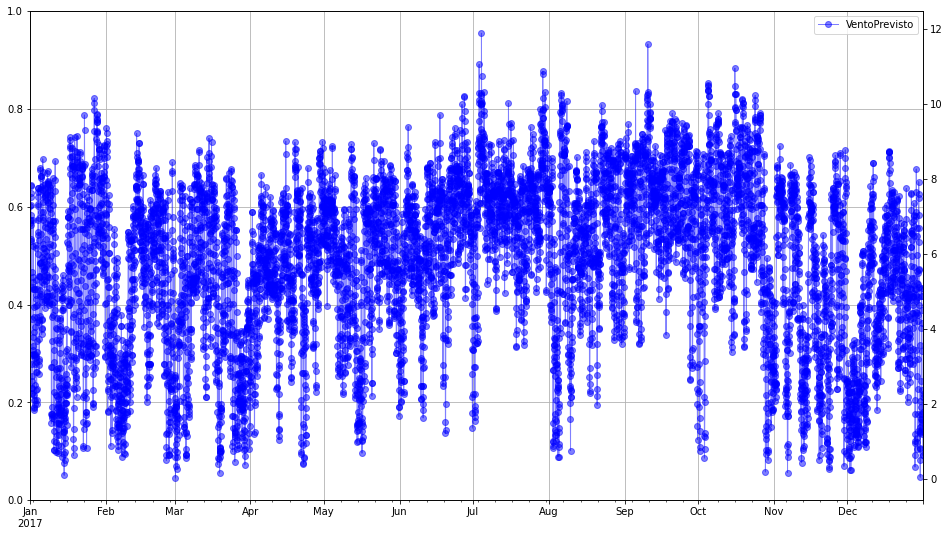

In [3]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='VentoPrevisto', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
#_ = df_day.plot(y='Direcao', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [4]:
df_day['V_d1'] = df_day['VentoPrevisto'].shift(-1)
df_day['V_l1'] = df_day['VentoPrevisto'].shift(1)
df_day['V_l2'] = df_day['VentoPrevisto'].shift(2)
df_day['V_l3'] = df_day['VentoPrevisto'].shift(3)
df_day['V_l4'] = df_day['VentoPrevisto'].shift(4)
df_day['V_l5'] = df_day['VentoPrevisto'].shift(5)
df_day['V_l6'] = df_day['VentoPrevisto'].shift(6)
df_day['V_l7'] = df_day['VentoPrevisto'].shift(7)

df_day['C_l1'] = df_day['Chuva'].shift(1)
df_day['C_l2'] = df_day['Chuva'].shift(2)
df_day['C_l3'] = df_day['Chuva'].shift(3)
df_day['C_l4'] = df_day['Chuva'].shift(4)
df_day['C_l5'] = df_day['Chuva'].shift(5)
df_day['C_l6'] = df_day['Chuva'].shift(6)
df_day['C_l7'] = df_day['Chuva'].shift(7)

df_day['D_l1'] = df_day['Direcao'].shift(1)
df_day['D_l2'] = df_day['Direcao'].shift(2)
df_day['D_l3'] = df_day['Direcao'].shift(3)
df_day['D_l4'] = df_day['Direcao'].shift(4)
df_day['D_l5'] = df_day['Direcao'].shift(5)
df_day['D_l6'] = df_day['Direcao'].shift(6)
df_day['D_l7'] = df_day['Direcao'].shift(7)

df_day['P_l1'] = df_day['Pressao'].shift(1)
df_day['P_l2'] = df_day['Pressao'].shift(2)
df_day['P_l3'] = df_day['Pressao'].shift(3)
df_day['P_l4'] = df_day['Pressao'].shift(4)
df_day['P_l5'] = df_day['Pressao'].shift(5)
df_day['P_l6'] = df_day['Pressao'].shift(6)
df_day['P_l7'] = df_day['Pressao'].shift(7)

df_day['T_l1'] = df_day['Temperatura'].shift(1)
df_day['T_l2'] = df_day['Temperatura'].shift(2)
df_day['T_l3'] = df_day['Temperatura'].shift(3)
df_day['T_l4'] = df_day['Temperatura'].shift(4)
df_day['T_l5'] = df_day['Temperatura'].shift(5)
df_day['T_l6'] = df_day['Temperatura'].shift(6)
df_day['T_l7'] = df_day['Temperatura'].shift(7)

complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases].copy()

In [5]:
# TRAINING
n_test_samples = 720
n_validation_samples = 720
random_seed = 720
lags = 7

#n_test_samples = 30
#n_validation_samples = 30
#random_seed = 32
#lags = 3


# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

x_cols = ['VentoPrevisto', 'V_l1','V_l2','V_l3','V_l4','V_l5','V_l6','V_l7',  'C_l1','C_l2','C_l3','C_l4','C_l5','C_l6','C_l7',  'D_l1','D_l2','D_l3','D_l4','D_l5','D_l6','D_l7',  'P_l1','P_l2','P_l3','P_l4','P_l5','P_l6','P_l7', 'T_l1','T_l2','T_l3','T_l4','T_l5','T_l6','T_l7']
y_cols = ['V_d1']

# PREPARING DATASET

# GETTING X
Xn = dfn[x_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(Xn)
Xn_scaled = X_scaler.transform(Xn)

# GETTING Y
Yn = dfn[y_cols].to_numpy()

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Yn)
Yn_scaled = Y_scaler.transform(Yn)

dataset = timeseries_dataset_from_array(Xn_scaled, Yn_scaled, lags)

In [6]:
data_atual = datetime.datetime.now()
print(data_atual)

2021-09-24 14:52:39.050684


In [7]:
# DECLARE NET
max_state = 5
PATIENCE = 1000
MAX_EPOCHS = 10*PATIENCE
LEARNING_RATE = 0.01
HIDDEN_ACTIVATION = 'relu'
MODEL_LOSS = 'loss'
MIN_IMPROVEMENT = 0.01
n_attributes = len(x_cols)

best_loss = 1000.0
training_result_list = []
for n_neurons in numpy.arange(max_state) + 1:
    
    inputs = keras.Input(shape=(lags, n_attributes))
    lstm_out = keras.layers.LSTM(n_neurons)(inputs)
    hidden = keras.layers.Dense(n_neurons, activation=HIDDEN_ACTIVATION)(lstm_out)
    outputs = keras.layers.Dense(Yn_scaled.shape[1], activation='linear')(hidden)
    
    model_name = 'FORECAST_{}_{}'.format(HIDDEN_ACTIVATION, n_neurons)
    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    myopt = tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    my_net.compile(optimizer=myopt, loss='mse')
    
    es_callback = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    
    history = my_net.fit(dataset, epochs=MAX_EPOCHS, callbacks=[es_callback], verbose=0)
    model_loss = history.history['loss'][-1]
    epochs = len(history.history['loss'])

    has_improved_val_loss = False
    loss_improvement = 1.0 - model_loss/best_loss

    if loss_improvement >= MIN_IMPROVEMENT:
        is_best_net = ((model_loss <= best_loss) & (model_loss < best_loss))

        if is_best_net:
                best_loss = model_loss
                best_val_loss = model_loss
                best_net = my_net
                best_history = history
                best_text = '***BEST NET!***'
                improvement_text = '{:.0f}% GAIN'.format(100.0*loss_improvement)
                best_name = model_name
                best_epochs = epochs
        else:
            best_text = ''
            improvement_text = ''
    else:
        print('EXTRA NEURON DIDNT IMPROVE NET {:.0f}% GAIN'.format(100.0*loss_improvement))
        break
    result_dict = {'model_name': model_name, 'epochs': epochs, 'model_loss': model_loss, 'model_val_loss': model_loss, 'best_net':is_best_net}
    training_result_list.append(result_dict)
    print('{} RESULTS > EPOCHS: {} LOSS: {:.3f} VAL_LOSS: {:.3f} {} {}'.format(model_name, epochs, model_loss, model_loss, best_text, improvement_text)) 

FORECAST_relu_1 RESULTS > EPOCHS: 1801 LOSS: 0.003 VAL_LOSS: 0.003 ***BEST NET!*** 100% GAIN
EXTRA NEURON DIDNT IMPROVE NET -531% GAIN


In [8]:
Y_est_scaled = best_net.predict(dataset)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)
y_len = Y_est.shape[0]
has_seq = dfn.index[-y_len:]
dfn.loc[has_seq, 'Y_est'] = Y_est

In [9]:
dfn.loc[has_seq,'residual'] = dfn.loc[has_seq,'Y_est'] - dfn.loc[has_seq,'V_d1']
dfn.loc[has_seq,'rabs'] = dfn.loc[has_seq,'residual'].abs()
model_r2_score = r2_score(dfn.loc[has_seq,'V_d1'].to_numpy(), dfn.loc[has_seq,'Y_est'].to_numpy())

In [10]:
data_atual = datetime.datetime.now()
print(data_atual)

2021-09-24 15:24:36.288501


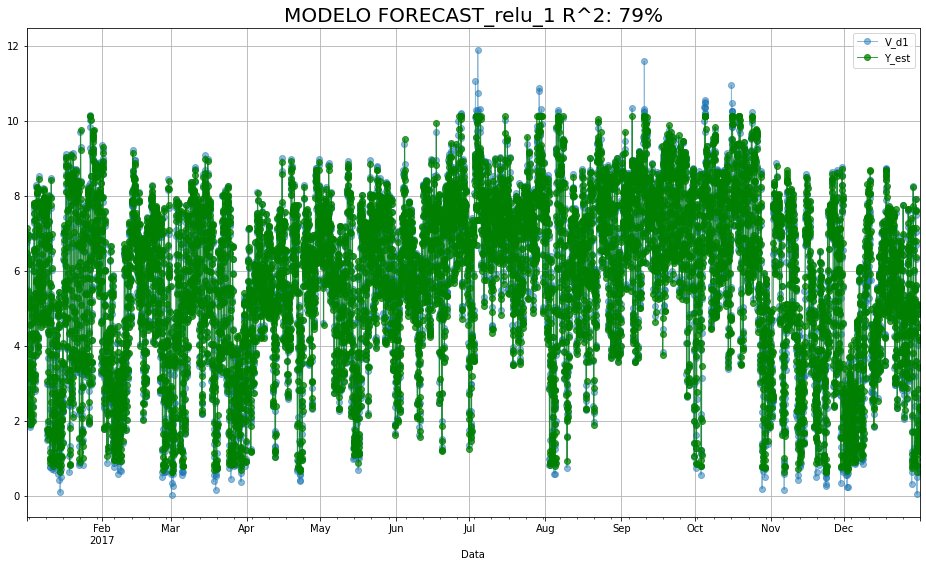

In [11]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
_ = dfn.plot(y='V_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = dfn.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.75, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(best_name, 100.0*model_r2_score), size=20)

In [12]:
dfn.sort_values('rabs', ascending=False)

,VentoPrevisto,Chuva,Pressao,Temperatura,Direcao,V_d1,V_l1,V_l2,V_l3,V_l4,...,T_l1,T_l2,T_l3,T_l4,T_l5,T_l6,T_l7,Y_est,residual,rabs
Data,,,,,,,,,,,,,,,,,,,,,
2017-01-20 01:00:00,5.27,0.00,1011.68,26.90,102.19,8.51,2.41,2.18,3.16,3.85,...,27.24,27.76,27.93,33.50,33.96,34.09,34.26,2.469433,-6.040567,6.040567
2017-01-24 03:00:00,4.72,0.00,1012.51,25.26,99.38,7.30,1.48,0.81,1.77,2.96,...,27.80,30.03,29.87,29.83,28.38,31.08,32.02,1.312847,-5.987153,5.987153
2017-03-03 02:00:00,4.70,0.00,1013.38,25.08,101.67,7.08,2.08,1.17,1.62,2.47,...,24.05,26.72,26.95,25.44,30.34,31.87,32.12,2.073488,-5.006512,5.006512
2017-09-30 21:00:00,5.36,0.00,1008.54,29.84,109.66,7.25,2.28,1.04,1.41,2.00,...,33.18,33.01,32.88,33.28,33.33,33.28,26.49,2.324021,-4.925979,4.925979
2017-08-05 06:00:00,3.74,0.00,1014.17,17.01,107.36,6.56,1.98,1.24,0.92,0.59,...,17.47,17.95,19.60,23.80,26.08,27.74,25.97,1.701134,-4.858866,4.858866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-30 21:00:00,6.61,0.05,1015.56,25.67,117.83,6.86,6.87,6.49,6.29,6.36,...,28.89,29.24,28.96,29.36,29.83,29.75,25.63,6.859408,-0.000592,0.000592
2017-07-04 12:00:00,10.73,0.00,1026.80,18.53,109.59,10.02,11.88,8.83,10.29,10.22,...,18.81,18.15,14.13,14.37,14.76,15.40,15.99,10.019426,-0.000574,0.000574
2017-06-20 12:00:00,6.33,0.00,1019.76,22.88,97.27,6.28,6.27,6.91,7.21,7.43,...,22.43,22.51,17.61,17.96,18.42,18.76,20.23,6.280003,0.000003,0.000003
